<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 20 - Deep learning and image tasks
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

**Discussing how to model/measure different ML problems**

- Deep learning tips and tricks
- Review of semantic segmentation
- Explanation of object detection and measurment
- 

## Deep learning tips and tricks

### Batch normalization: 

From [Ioffe et al., "Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift"](https://arxiv.org/pdf/1502.03167v3)

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Batch normalization is simply another modle layer where: 

---

**Input**: Values of $x$ over a mini-batch: $\mathcal{B} = \{x_1 \dots x_m\}$;  
Parameters to be learned: $\gamma, \beta$  
**Output**: $\{y_i = \text{BN}_{\gamma,\beta}(x_i)\}$

$$
\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i \qquad \text{// mini-batch mean}
$$

$$
\sigma^2_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_{\mathcal{B}})^2 \qquad \text{// mini-batch variance}
$$

$$
\hat{x}_i \leftarrow \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma^2_{\mathcal{B}} + \epsilon}} \qquad \text{// normalize}
$$

$$
y_i \leftarrow \gamma \hat{x}_i + \beta \equiv \text{BN}_{\gamma,\beta}(x_i) \qquad \text{// scale and shift}
$$

**Algorithm 1**: Batch Normalizing Transform, applied to activation $x$ over a mini-batch.

---

This will normalize the mini-batch as seen below: 

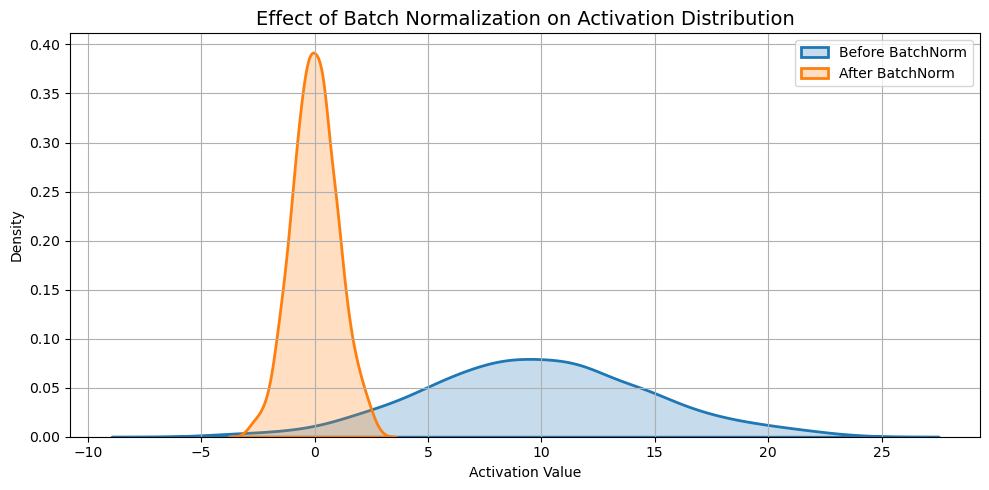

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate a batch of pre-activation outputs
np.random.seed(0)
raw_activations = np.random.randn(1000) * 5 + 10  # High variance, non-zero mean

# Apply batch normalization manually
mean = np.mean(raw_activations)
std = np.std(raw_activations)
normalized = (raw_activations - mean) / std

# Apply affine transform (optional: here gamma=1, beta=0)
gamma = 1.0
beta = 0.0
batchnorm_output = gamma * normalized + beta

# Plot the distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(raw_activations, label='Before BatchNorm', fill=True, linewidth=2)
sns.kdeplot(batchnorm_output, label='After BatchNorm', fill=True, linewidth=2)
plt.title("Effect of Batch Normalization on Activation Distribution", fontsize=14)
plt.xlabel("Activation Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Batch normalization leads to more stable and improved training: 

<div>
    <center><img src="img/batch_results.png" width="500"></center>
</div>

Look at Resnet-18 (pre-trained ImageNet model) for use of batch normaliation: 

In [ ]:
### from https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels) ###############################
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Semantic segmentation review

<div>
    <center><img src="img/semantic-segmentation-example.png" width="500"></center>
</div>

Consider the above figure depicting a semantic segmentation example. Each pixel in this image is assigned its own label, like how we provide an image-level label for image classification. To accomplish such a task, we often use **encoder-decoder** CNN model architectures also known as **autoencoders**. The encoder stage proceeds like a normal CNN where successive convolutional layers and pooling layers reduce the spatial resolution of feature maps. The encoder and decoder stages meet at a bottleneck where the decoder stage begins upsampling the feature maps back towards the desired output resolution. Where the encoder stage applies pooling or strided convolution, the decoder stage performs **upsampling** or **transposed convolution** to increase the spatial resolution of feature maps. Finally, once the desired resolution is reached, we may use a $1\times 1$ 2D convolution layer to combine the feature maps in the last layer to provide final class scores at each pixel like how a fully connected layer does for regular image classification.

Such CNNs have no fully-connected layers (and in fact may avoid all pooling layers as well) and thus we refer to them as **fully convolutional networks** (FCN). An example autoencoder model is shown below.

<div>
    <center><img src="img/autoencoder-example.png" width="600"></center>
</div>

### U-Net

One highly popular semantic segmentation architecture is known as [U-Net](https://arxiv.org/pdf/1505.04597) (Ronneberger, et al. 2015). The authors introduce a novel autoencoder-based model that incorporates connections between encoder feature maps and decoder feature maps. The intuition behind this choice is to allow feature learning that combines earlier primitive features from the encoder with more complex representations from the decoder. For each connection, the feature maps of the encoder and decoder (at the same spatial resolution) are simply concatenated along the feature channel dimension. The below figure demonstrates a U-Net model with two encoder/decoder stages for a binary segmentation problem; thus, the output of the last convolution is passed through a sigmoid layer. The number of channels is set by a base width $L$ and the label underneath each convolutional layer is the number of output layers. In the below figure, yellow prisms are convolutional layers, orange prisms perform downsampling by maxpooling, blue prisms perform upsampling, and green plus symbols concatenate feature maps.

<div>
    <center><img src="img/u-net.png" width="800"></center>
</div>

## Object Detection
### Problem Statement
The objective of any object detection problem is to place bounding boxes over every object of interest in an image and also classify the object inside of that box. Every instance of a given class must be separately identified. Thus, we may have many different objects that must be localized and separated by class as seen below.
<div>
    <center><img src="img/object-detection-example.png" width="500"></center>
</div>
More formally, for an (RGB) image $\mathbf{X}\in\mathbb{R}^{3\times H\times W}$ with $K$ annotations across $C$ possible classes, $\mathbf{Y}\in\mathbb{A}^{K}$ represents the annotations where $Y_i\in\mathbb{A}=\{1, 2, \ldots, C\}\times\mathbb{R}^{4}$. Each annotation must identify one of the $C$ classes as well as four coordinates specifying the dimensions of the bounding box. Multiple standards may be chosen for the bounding box, we will opt to specify the coordinates in the form of $(x_{\textrm{min}}, y_{\textrm{min}}, x_{\textrm{max}}, y_{\textrm{max}})\in[0, 1]^{4}$. In this format, the coordinates are normalized from 0 to 1 relative to the height and width of the image while $(x_{\textrm{min}}, y_{\textrm{min}})$ and $(x_{\textrm{max}}, y_{\textrm{max}})$ enumerate the top-left and bottom-right corners of the bounding box. In summary, the annotations for an image in the context of object detection may contain $K>1$ annotations where each annotation specifies the class, top-left corner, and bottom-right corner of the bounding box that tightly holds the object.

### Single-stage Object Detection
Object detectors are separated into two main groups: single-stage and two-stage detectors. In this lecture, we will focus on single-stage detectors and in particular the Single Shot Multibox Detector, also known as SSD. An implementation of [SSD](https://pytorch.org/vision/main/models/ssd.html) and a lightweight [SSDLite](https://pytorch.org/vision/main/models/ssdlite.html) version may be found in PyTorch here. At a high level, the SSD model creates many convolutional feature maps that have hard-coded **anchors** or **default boxes** in the image. The SSD model, and similar single-stage models, have multiple scales or resolution for these pre-defined boxes. For the feature maps at a given scale, each pixel location at that scale defines a center point relative to the image dimensions, e.g for a $16\times 16$ feature map, the pixel at location $(2, 1)$ would be centered at $(2.5/16, 1.5/16)$ of the height and width of the image (accounting for offsetting to the center of each square in the image grid). In addition to the center point and a given scale, we may also pre-determine certain aspect ratios, e.g. 1:1, 1:2, 3:1 for width:height. The below figure depicts example default boxes at two scaled in SSD.

<div>
    <center><img src="img/default-boxes.png" width="500"></center>
</div>

For the SSD model, we have $m$ default box scales. For scale $s_k, k\in[1, m]$, we determine the scale as 
$$
s_k= s_{\textrm{min}}+\frac{s_{\textrm{max}}-s_{\textrm{min}}}{m-1},
$$
where $s_{\textrm{min}}$ and $s_{\textrm{max}}$ are chosen as 0.2 and 0.9 in the SSD paper but may be adjusted in practice. For a feature map at scale $s_k$ of size $H_k\times W_k$, the center point at pixel location $(i, j)$ will correspond to location
$$
\left(\frac{i+0.5}{W_k}, \frac{j+0.5}{H_k}\right)
$$
in the original image. Thus, we have a center point and scale for each default box. Lastly, we pre-define aspect ratios $a_r\in\{1, 2, 3, 1/2, 1/3\}$ to set multiple available heights and widths for default boxes at the given center location and scale. The result height and width at scale $k$ and aspect ratio $a_r$ is given by
$$
\begin{align}
h_k^a &= \frac{s_k}{\sqrt{a_r}}\\
w_k^a &= s_k\sqrt{a_r}.
\end{align}
$$
Finally, the SSD authors also define a sixth aspect ratio that is also 1:1 but at the intermediate scale of $s_k'=\sqrt{s_ks_{k+1}}$. In total, the original SSD model proposed for $300\times 300$ images has $8,\!732$ default boxes across 6 feature scales.

### Positive and Negative Default Boxes

For all the available default boxes in an SSD model, they may be separated into positive and negative groups. A default box is determined as a positive box if it has intersection over union (IoU) of at least 0.5 with a ground-truth object box. Thus, multiple default boxes may be positive for a given object box. All other default boxes are seen as negative; therefore, there is a large imbalance where many more negative default boxes will exist than positive default boxes.

<div>
    <center><img src="img/FP_vs_TP.png" width="800"></center>
</div>

[Source](https://www.v7labs.com/blog/mean-average-precision)

### Predictions at Default Boxes

To create one scale of default box predictions in SSD, we use a convolutional layer with $3\times 3$ kernels, padding of one, and stride one. Suppose the input to this layer at scale $k$ is $Z_k\in\mathbb{R}^{C_k\times H_k \times W_k}$. The resulting convolutional layer will have $6\times (C+1+4)$ output channels. The number of output channels is broken down as follows:
$$
\textrm{\# of Output Channels} = \underbrace{6}_{\textrm{number of aspect ratios}}\times\left(\underbrace{C+1}_{C~\textrm{foreground classes}+1~\textrm{background class}} + \underbrace{4}_{\textrm{bounding box offsets}}\right)
$$

The four bounding box offsets are defined as $(\Delta c_x, \Delta c_y, \Delta w, \Delta h)\in\mathbb{R}_+^4$ to indicate proportional changes in the center point, height, and width of the bounding box going from pre-defined default box to the ground-truth object box. Thus, these offsets perform a regression task to make minor adjustments to better fit default boxes with significant object overlap. The below figure depicts the architecture of the SSD model.

<div>
    <center><img src="img/ssd.png" width="800"></center>
</div>

### Training Object Detectors

Using these default boxes, both positive and negative, we may finally define the necessary loss function to train the fully convolution SSD model (and similar single-stage detectors). Let $x_{ij}^p\in\{0, 1\}$ be an indicator of matching default box $i$ to ground-truth box $j$ from class $p$, $c$ be the class of the bounding box, $l$ be the predicted bounding box, $g$ be the ground-truth bounding box, and $d$ be the matched default box. The loss function $\mathcal{L}$ is given as
$$
\mathcal{L}(x, c, l, g) = \frac{1}{N}\left(\mathcal{L}_{\textrm{cls}}(x, c) +\alpha\mathcal{L}_{\textrm{loc}}(x, l, g)\right),
$$
where $N$ is the number of matched default boxes for the given image and
$$
\begin{align}
    \mathcal{L}_{\textrm{loc}}(x, l, g) &= \sum_{i\in\textrm{Positive Boxes}}^{N}\sum_{a\in\{cx, cy, w, h\}}x_{ij}^{k}\textrm{Smooth}L1(l_i^a-\hat{g}_j^a)\\
    \hat{g}_j^{cx} &= \frac{g_j^{cx}-d_i^{cx}}{d_i^{w}}\\
    \hat{g}_j^{cy} &= \frac{g_j^{cy}-d_i^{cy}}{d_i^{h}}\\
    \hat{g}_j^{w} &= \log\left(\frac{g_j^w}{d_i^w}\right)\\
    \hat{g}_j^{h} &= \log\left(\frac{g_j^h}{d_i^h}\right).
\end{align}
$$
Thus, the localization loss seeks to regress the relative offsets of the well-matched default boxes, i.e. slightly shift the center point or increase/decrease the height or width using the [Smooth L1 loss function](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The classification loss is simply cross-entropy loss where we apply softmax to the class probabilities and maximize the probability of the ground-truth class. Negative default boxes then seek to maximize the probability of the background or 0 class. Finally, the value of $\alpha> 0$ is a hyperparameter to balance the classification and localization losses. Empirically, the authors choose this value as one.

### Inference in Object Detectors
In order to evaluate an object detector, we must have a procedure to perform **inference** and produce final predictions of bounding boxes and object classes. Our model will have thousands of default boxes each with class scores and box offsets; thus, we will first filter out boxes that are likely mostly overlapping with the background and not with objects. A class probability threshold is typically set for the highest-probability foreground class, e.g. 0.02, to identify possible object boxes. Even with such a low threshold, most of the default boxes will be filtered out. For a single object, there may be several remaining default boxes that overlap with the object of interest. Thus, we must devise a way to de-duplicate boxes. 

### Non-maximum Suppression (NMS)
The method of non-maximum suppression (NMS) is commonly used to produce the final predictions for object bounding boxes. After class score thresholding, NMS sorts the default boxes in descending order of the highest non-background class probability. Working in order through the default boxes, we remove any lower-probabilitiy default boxes with an overlap (IoU) greater than some threshold, e.g. 0.4. After NMS, we will have a collection of bounding boxes with relatively little overlap and well-defined class scores that predict some object class. 

<div>
    <center><img src="img/nms_2.png" width="800"></center>
</div>

[source](https://arxiv.org/pdf/2304.00501)

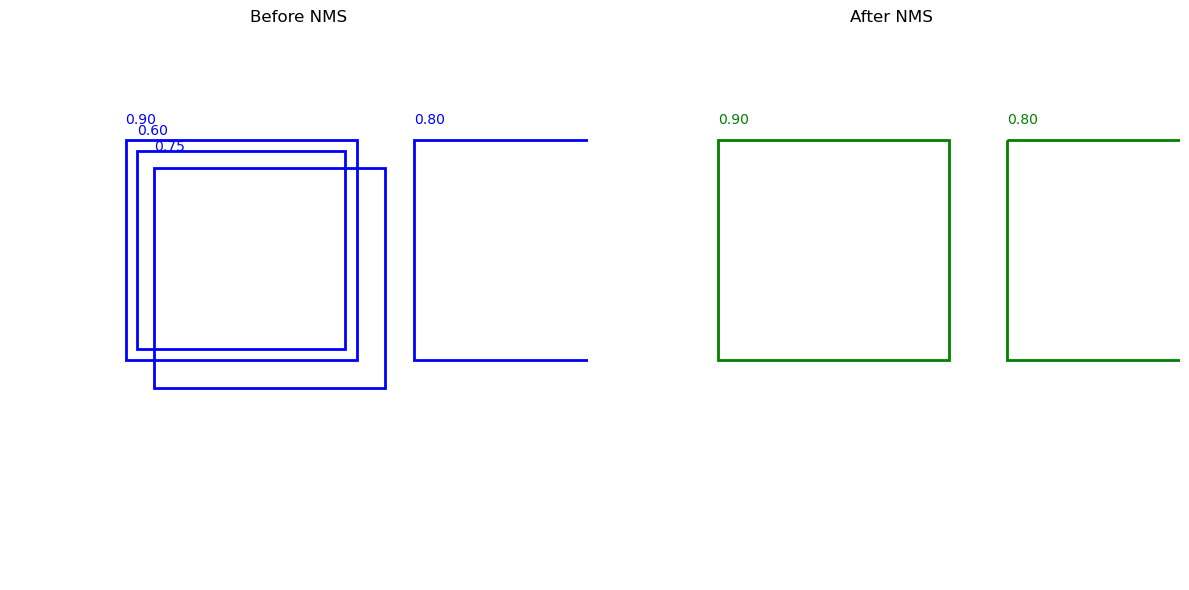

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def iou(box1, box2):
    """Compute IoU between two boxes."""
    x1, y1, x2, y2 = box1
    x1b, y1b, x2b, y2b = box2

    xi1 = max(x1, x1b)
    yi1 = max(y1, y1b)
    xi2 = min(x2, x2b)
    yi2 = min(y2, y2b)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2b - x1b) * (y2b - y1b)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0

def non_max_suppression(boxes, scores, iou_thresh=0.5):
    """Perform Non-Maximum Suppression."""
    indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    keep = []

    while indices:
        current = indices.pop(0)
        keep.append(current)
        indices = [i for i in indices if iou(boxes[current], boxes[i]) < iou_thresh]

    return keep

def draw_boxes(ax, boxes, scores, color='blue', label='Before NMS'):
    """Draw bounding boxes."""
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 3, f"{scores[i]:.2f}", color=color, fontsize=10)
    ax.set_title(label)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.invert_yaxis()
    ax.axis('off')

# Sample boxes and confidence scores
boxes = [
    [20, 20, 60, 60],
    [25, 25, 65, 65],
    [70, 20, 110, 60],
    [22, 22, 58, 58],  # Highly overlapping with the first box
]
scores = [0.9, 0.75, 0.8, 0.6]

# Apply NMS
keep_indices = non_max_suppression(boxes, scores, iou_thresh=0.5)
boxes_nms = [boxes[i] for i in keep_indices]
scores_nms = [scores[i] for i in keep_indices]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
draw_boxes(ax1, boxes, scores, color='blue', label='Before NMS')
draw_boxes(ax2, boxes_nms, scores_nms, color='green', label='After NMS')
plt.tight_layout()
plt.show()

### Average Precision (AP) and Mean Average Precision (mAP)

<img align="left" src="img/precision_recall.png" width="300px" style="padding:30px;border:thin solid white;" alt="https://www.youtube.com/watch?v=FppOzcDvaDI"> 

The most popular metric for evaluating object detection models is known as Average Precision (AP). For each predicted bounding box, it may be categorized as one of two things:
* True Positive (TP): Overlaps with an object and predicts the correct class
* False Positive (FP): Does not sufficiently overlap with an object and/or predicts the incorrect class.

Furthermore, for each ground-truth bounding box, it is referred to as a **False Negative** (FN) if no predicted bounding box matches with it. For a given class probability threshold (i.e. remove boxes below this threshold), every bounding-box will be either a TP or an FP, while any unmatched ground-truth boxes will default to FN. Using these three quantities by counting the number of TP, FP, and FN boxes, we may compute **precision** and **recall**:
$$
\begin{align}
    \textrm{Precision} &= \frac{TP}{TP+FP}\in [0, 1]\\
    \textrm{Recall} &= \frac{TP}{TP+FN}\in [0, 1.
\end{align}
$$
Intuitively, precision evaluates how often our model is correct when it identifies an object while recall evaluates what proportion of objects our model is able to find. A model that only predicts one object box but is correct will have high precision but low recall. Conversely, a model that predicts many bounding boxes will likely have high recall and find all the objects but may have low precision since many predicted boxes will be false positives. 

As we lower the class probability threshold from 1 down to 0, the precision will typically drop while the recall rises. The resulting series of points forms the **precision-recall curve** (PRC). The metric of Average Precision is the area under the precision-recall curve (also referred to as AUPRC). [This video is helpful to visualize the PRC and how we compute AP.](https://www.youtube.com/watch?v=FppOzcDvaDI).

### Example (from [Hui et al.](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173))

> Let’s create an over-simplified example in demonstrating the calculation of the average precision. In this example, the whole dataset contains 5 apples only. We collect all the predictions made for apples in all the images and rank it in descending order according to the predicted confidence level. The second column indicates whether the prediction is correct or not. In this example, the prediction is correct if IoU ≥ 0.5.

<img align="right" src="img/pr_curve_example.png" width="600px" style="padding:30px;border:thin solid white;" alt="https://www.youtube.com/watch?v=FppOzcDvaDI"> 


| Rank | Correct? | Precision | Recall |
|------|----------|-----------|--------|
| 1    | True     | 1.0 ↑     | 0.2 ↑  |
| 2    | True     | 1.0 →     | 0.4 ↑  |
| 3    | False    | 0.67 ↓    | 0.4 →  |
| 4    | False    | 0.5 ↓     | 0.4 →  |
| 5    | False    | 0.4 ↓     | 0.4 →  |
| 6    | True     | 0.5 ↑     | 0.6 ↑  |
| 7    | True     | 0.57 ↑    | 0.8 ↑  |



Average Precision also requires we specify an IoU threshold to determine if two overlapping boxes overlap enough to be considered a true positive or a false positive. Thus, we often will have a subscript, e.g. $\textrm{AP}_{0.5}$, to indicate an IoU threshold for computing Average Precision. Finally, the metric of **mean Average Precision** (mAP) is the average of AP at multiple IoU thresholds, typically from 0.5 to 0.95 in increments of 0.05.

### So so so many AP variations....

1. **mAP@IoU=0.5 (PASCAL VOC style)**
   - Calculates average precision at a fixed IoU threshold of 0.5.
   - Common in early object detection benchmarks.
   - [VOC Challenge Evaluation](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html#evaluation)

2. **mAP@[.5:.95] (COCO style)**
   - Averages AP over multiple IoU thresholds from 0.5 to 0.95 in 0.05 increments.
   - More strict and comprehensive.
   - [COCO Evaluation Metrics](https://cocodataset.org/#detection-eval)

3. **mAP per Class**
   - Computes AP separately for each class and averages them.
   - Useful for evaluating per-class performance.
   - [Detectron2 Metrics Documentation](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.COCOEvaluator)

4. **mAP@N (e.g., mAP@10)**
   - Common in information retrieval: computes AP over top-N ranked predictions.
   - [Wikipedia: Mean Average Precision](https://en.wikipedia.org/wiki/Information_retrieval#Mean_average_precision)

5. **mAP with Soft Matching**
   - Uses a softened notion of matching rather than strict IoU thresholds.
   - Sometimes used in medical imaging or semantic segmentation.
   - [Soft-NMS Paper (CVPR 2017)](https://arxiv.org/abs/1704.04503)

6. **mAP Weighted by Object Size**
   - Evaluates mAP across object sizes: small, medium, large.
   - Included in COCO metrics.
   - [COCO Object Sizes Explained](https://cocodataset.org/#detection-eval)

7. **Normalized mAP**
   - Adjusts for class imbalance by normalizing per-class contributions.
   - Useful in highly imbalanced datasets.
   - [Survey on Object Detection Metrics (Section 4)](https://arxiv.org/abs/2006.06668)

### Multi-scale detection

One of the issues with object detection in a standard grid is that it typically doesn't do to well with object of significantly different scales. That's why modern image models output multi-resolution outputs:

<div>
    <center><img src="img/yolov3.png" width="500"></center>
</div>

[source](https://arxiv.org/pdf/2304.00501)

## Encoder-Decoder models 

**Transfer learning** is a machine learning technique in which knowledge gained through one task or dataset is used to improve model performance on another related task and/or different dataset. 

One of the benefits of the encoder-decoder architecture is for transfer learning. 

<div>
    <center><img src="img/pretrained_models.png" width="800"></center>
</div>




For example, the [YOLO model(s)](https://arxiv.org/pdf/2309.16921)

<div>
    <center><img src="img/multi-task-yolo.png" width="800"></center>
</div>

<div>
    <center><img src="img/multi-task-yolo-outputs.png" width="800"></center>
</div>

[source](https://arxiv.org/pdf/2309.16921)

There are a myriad of pretrained image models to choose from (many of which are available directly in [torchvision](https://pytorch.org/vision/main/models.html)).

## That's it for today

- Kaggle infrastructure is done. Updated announcements about the project on incoming. 
- Thursday we will begin our discussion of transformers and LLMs!